# Install Kornia

In [1]:
#!pip install git+https://github.com/kornia/kornia

import kornia
print(f"Kornia version: {kornia.__version__}")

Kornia version: 0.2.0+cb9373b


# Import needed libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# computer vision libs :D

import cv2
import kornia

In [3]:
def resize(image, height, width):
    return F.interpolate(image, size=(height, width), mode='nearest')

## Input Parameters


In [4]:
input_dir = './data/homography'
src_name = 'img1.ppm'  # source image file
dst_name = 'img2.ppm'  # destination image file
learning_rate = 1e-3
num_iterations = 100
num_levels = 8
error_tol = 1e-8

log_interval = 100  # print log every N iterations
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cpu


In [5]:
def load_image(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor                                      
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)

    # load image with OpenCV                                                                         
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)

    # convert image to torch tensor                                                                  
    tensor = kornia.image_to_tensor(img).float() / 255. # CxHxW
    return tensor[None] # 1xCxHxW

### Container to hold the homography as a trainable parameter

In [6]:
class MyHomography(nn.Module):
    def __init__(self):
        super(MyHomography, self).__init__()
        self.homography = nn.Parameter(torch.Tensor(3, 3))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.eye_(self.homography)

    def forward(self):
        return torch.unsqueeze(self.homography, dim=0)  # 1x3x3  

### Read images and convert  to tensor

torch.Size([1, 3, 640, 800])
torch.Size([1, 3, 640, 800])
tensor([[[ 8.7977e-01,  3.1245e-01, -3.9431e+01],
         [-1.8389e-01,  9.3847e-01,  1.5316e+02],
         [ 1.9641e-04, -1.6015e-05,  1.0000e+00]]])


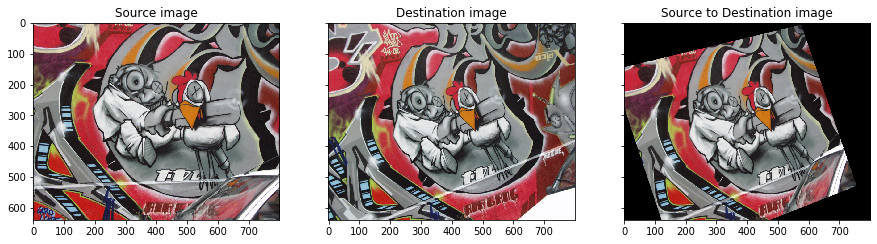

In [7]:
img_src = load_image(os.path.join(input_dir, src_name))
img_dst = load_image(os.path.join(input_dir, dst_name))
print(img_src.shape)
print(img_dst.shape)

dst_homo_src_gt = np.loadtxt(os.path.join(input_dir, 'H1to2p'))
dst_homo_src_gt = torch.from_numpy(dst_homo_src_gt)[None].float()
print(dst_homo_src_gt)

height, width = img_src.shape[-2:]

# warp image in normalized coordinates
normal_transform_pixel = kornia.normal_transform_pixel(height, width)

dst_homo_src_gt_norm = normal_transform_pixel @ dst_homo_src_gt @ torch.inverse(normal_transform_pixel)

img_src_to_dst_gt = kornia.homography_warp(
    img_src, torch.inverse(dst_homo_src_gt_norm), (height, width))

img_src_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_src))
img_dst_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_dst))
img_src_to_dst_gt_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_src_to_dst_gt))

%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

ax1.imshow(img_src_vis)
ax1.set_title('Source image')

ax2.imshow(img_dst_vis)
ax2.set_title('Destination image')

ax3.imshow(img_src_to_dst_gt_vis)
ax3.set_title('Source to Destination image')
plt.show()

### Initialize the warper and the homography

In [8]:
# create homography parameters
dst_homo_src = MyHomography()

# create optimizer
optimizer = optim.Adam(dst_homo_src.parameters(), lr=learning_rate)

# send data to device
img_src, img_dst = img_src.to(device), img_dst.to(device)

In [9]:
### compute Gaussian Pyramid

def get_gaussian_pyramid(img: torch.Tensor, num_levels: int) -> torch.Tensor:
    r"""Utility function to compute a gaussian pyramid."""
    pyramid = []
    pyramid.append(img)
    for _ in range(num_levels - 1):
        img_curr = pyramid[-1]
        img_down = kornia.pyrdown(img_curr)
        pyramid.append(img_down)
    return pyramid

# compute the gaussian pyramids
img_src_pyr = get_gaussian_pyramid(img_src, num_levels)
img_dst_pyr = get_gaussian_pyramid(img_dst, num_levels)

### Main optimization loop

This is the loss function to minimize the photometric error:
 $ L = \sum |I_{ref} - \omega(I_{dst}, H_{ref}^{dst}))|$

In [10]:
def compute_scale_loss(img_src: torch.Tensor,
                       img_dst: torch.Tensor,
                       dst_homo_src: nn.Module,
                       optimizer: torch.optim,
                       num_iterations: int,
                       error_tol: float) -> torch.Tensor:
    assert len(img_src.shape) == len(img_dst.shape), (img_src.shape, img_dst.shape)
    
    # init loop parameters
    loss_tol = torch.tensor(error_tol)
    loss_prev = torch.finfo(img_src.dtype).max
    
    for i in range(num_iterations):
        # create homography warper
        src_homo_dst: torch.Tensor = torch.inverse(dst_homo_src)

        _height, _width = img_src.shape[-2:]
        warper = kornia.HomographyWarper(_height, _width)
        img_src_to_dst = warper(img_src, src_homo_dst)

        # compute and mask loss
        loss = F.l1_loss(img_src_to_dst, img_dst, reduction='none') # 1x3xHxW

        ones = warper(torch.ones_like(img_src), src_homo_dst)
        loss = loss.masked_select((ones > 0.9)).mean()

        # compute gradient and update optimizer parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(loss)

tensor(0.0338, grad_fn=<MeanBackward0>)
Train iteration: 0/8
tensor([[[ 1.0310e+00,  4.3389e-02, -3.5622e-02],
         [-6.3613e-04,  1.0006e+00,  7.2077e-02],
         [ 2.1462e-02,  4.3116e-02,  9.7352e-01]]],
       grad_fn=<UnsqueezeBackward0>)
Reprojection error: 0.138986274600029


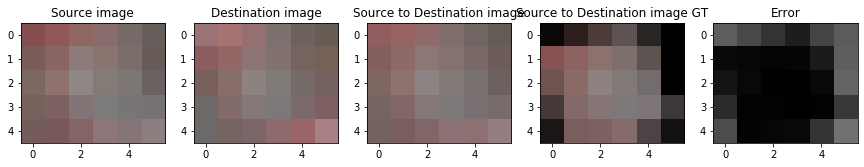

tensor(0.0659, grad_fn=<MeanBackward0>)
Train iteration: 1/8
tensor([[[ 1.0541,  0.1027,  0.0157],
         [-0.0289,  0.9888,  0.1282],
         [ 0.0594,  0.0853,  0.9507]]], grad_fn=<UnsqueezeBackward0>)
Reprojection error: 0.15621612966060638


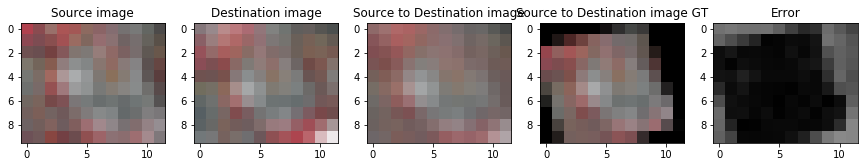

tensor(0.1095, grad_fn=<MeanBackward0>)
Train iteration: 2/8
tensor([[[ 0.9688,  0.1412,  0.0543],
         [-0.0288,  1.0265,  0.2052],
         [ 0.0362,  0.1605,  0.9852]]], grad_fn=<UnsqueezeBackward0>)
Reprojection error: 0.16567495465278625


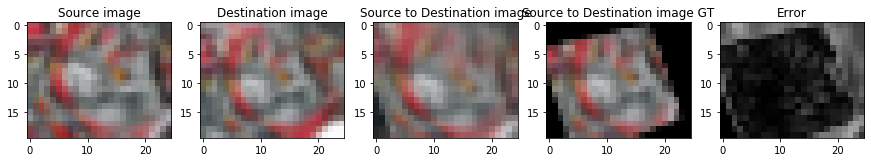

tensor(0.1426, grad_fn=<MeanBackward0>)
Train iteration: 3/8
tensor([[[ 0.9560,  0.1959,  0.0385],
         [-0.1324,  0.9452,  0.2601],
         [-0.0395,  0.1070,  1.0413]]], grad_fn=<UnsqueezeBackward0>)
Reprojection error: 0.14160631597042084


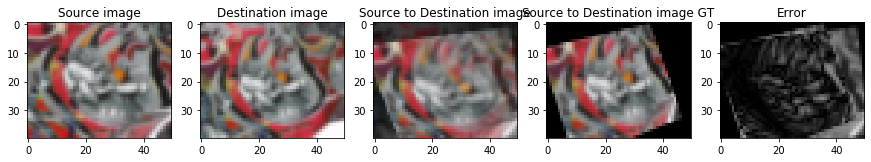

tensor(0.1663, grad_fn=<MeanBackward0>)
Train iteration: 4/8
tensor([[[ 0.8596,  0.2662, -0.0589],
         [-0.3158,  0.9678,  0.1172],
         [ 0.0037, -0.0359,  1.1107]]], grad_fn=<UnsqueezeBackward0>)
Reprojection error: 0.07031933963298798


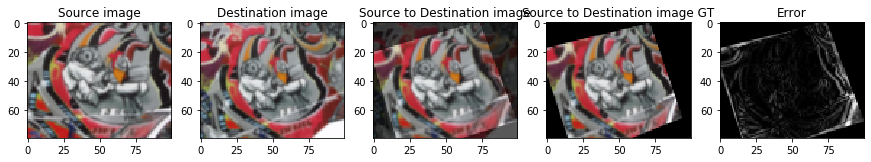

tensor(0.1094, grad_fn=<MeanBackward0>)
Train iteration: 5/8
tensor([[[ 0.8352,  0.2659, -0.0441],
         [-0.3217,  0.9824,  0.1203],
         [ 0.0823, -0.0053,  1.1197]]], grad_fn=<UnsqueezeBackward0>)
Reprojection error: 0.004240119364112616


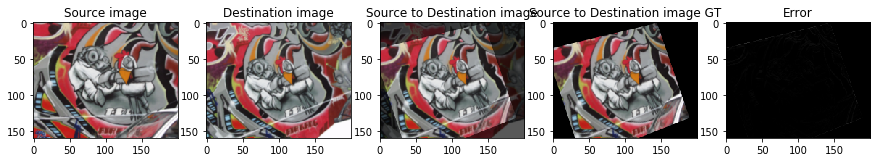

tensor(0.0363, grad_fn=<MeanBackward0>)
Train iteration: 6/8
tensor([[[ 0.8354,  0.2660, -0.0441],
         [-0.3214,  0.9827,  0.1198],
         [ 0.0821, -0.0057,  1.1196]]], grad_fn=<UnsqueezeBackward0>)
Reprojection error: 0.004232392646372318


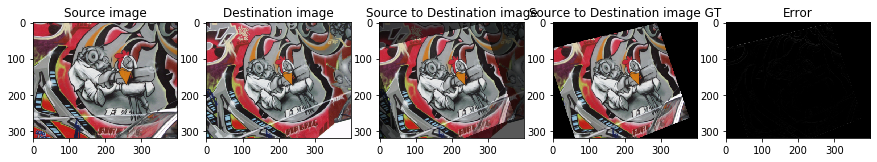

tensor(0.0442, grad_fn=<MeanBackward0>)
Train iteration: 7/8
tensor([[[ 0.8355,  0.2660, -0.0441],
         [-0.3214,  0.9828,  0.1196],
         [ 0.0819, -0.0060,  1.1196]]], grad_fn=<UnsqueezeBackward0>)
Reprojection error: 0.005433832760900259


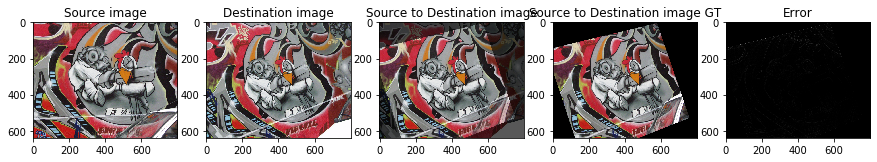

In [11]:
# pyramid loop

for iter_idx in range(num_levels):
    # get current pyramid data
    scale = (num_levels - 1) - iter_idx
    img_src = img_src_pyr[scale]
    img_dst = img_dst_pyr[scale]

    # compute scale loss
    compute_scale_loss(img_src, img_dst, dst_homo_src(),
                       optimizer, num_iterations, error_tol)

    print('Train iteration: {}/{}'.format(iter_idx, num_levels))
    print(dst_homo_src())
       
    # merge warped and target image for visualization
    _height, _width = img_src.shape[-2:]
    warper = kornia.HomographyWarper(_height, _width)
    img_src_to_dst = warper(img_src, torch.inverse(dst_homo_src()))
    img_src_to_dst_gt = warper(img_src, torch.inverse(dst_homo_src_gt_norm))

    # compute the reprojection error
    error = F.l1_loss(img_src_to_dst, img_src_to_dst_gt, reduction='none')
    print('Reprojection error: {}'.format(error.mean()))
    
    # show data
    img_src_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_src))
    img_dst_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_dst))
    img_src_to_dst_merge = 0.65 * img_src_to_dst + 0.35 * img_dst
    img_src_to_dst_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_src_to_dst_merge))
    img_src_to_dst_gt_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_src_to_dst_gt))
    
    error_sum = error.mean(dim=1, keepdim=True)
    error_vis = kornia.tensor_to_image(error_sum)

    %matplotlib inline
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    ax1.imshow(img_src_vis)
    ax1.set_title('Source image')

    ax2.imshow(img_dst_vis)
    ax2.set_title('Destination image')

    ax3.imshow(img_src_to_dst_vis)
    ax3.set_title('Source to Destination image')
    
    ax4.imshow(img_src_to_dst_gt_vis)
    ax4.set_title('Source to Destination image GT')
    
    ax5.imshow(error_vis, cmap='gray', vmin=0, vmax=1)
    ax5.set_title('Error')
    plt.show()